# CAB420, Neural Attention, Example 2: Transformers
Dr Simon Denman (s.denman@qut.edu.au)

# Overview

Transformers are a specific class of feed-foward network that achieve state of the art performance for sequence processing tasks, and dominante Natural Language Processing (NLP). While they were originally proposed for language tasks, we're now seeing them dominate everything else too. Unlike recurrent models which store an internal memory to keep track of data over the sequence, transformers do not use memory or recurrent steps, and process the entire sequence at once. One of the main motivations for this to increase the parallelisation of the networks, allowing them to run faster in large (and expensive) GPU configurations. Attention is used liberally to help the model understand connections and relationships in the data.

For most tasks, multiple transformer units are stacked, allowing information to be extracted by successive passes through attention blocks. For sequence to sequence tasks, transformers are used to encode and then decode the representation, much like we've seen in auto-encoder or other image-to-image networks.

This example will keep things simple. We won't look the decoder stage which is used in applications such as language translation, adn we'll just use in-built layers to do the operations that we need.

For those who are interested in further reading regarding transformers, the following are good starting places:
* [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
* [Tensor 2 Tensor Notebook (contains cool visualisation)](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)
* [Attention is all you need (the paper that introduced this architecture)](https://arxiv.org/abs/1706.03762)

To clarify, thankfully Michael Bay has no involvement what so ever in this example (although a few gratuitous explosions would be fun).

## Too Long; Didn't Read:
* Transformers offer an alternate way to process sequences, where the entire sequences is processed concurrently rather than sequentially as per an LSTM
* Inputs and outputs are sequences. Like an LSTM, inputs are embeddings, but unlike an LSTM the embedding captures information on the token **and it's position** in the sequence
* Transformer blocks can be stacked, like an LSTM
* Transformers are not, in the majority of cases, super efficient computionally. They offer much greater parallelisation than an LSTM, but you need to have large GPU resources, and be processing long sequences, to really benefit from this.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas
import numpy
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from keras.preprocessing.sequence import pad_sequences
import keras_nlp
from keras import layers
from keras.utils import model_to_dot, plot_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

tf.config.optimizer.set_jit(False)

/tmp/ipykernel_19375/1844558858.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


## The Data
Still twitter data. Same setup as last time - though we're taking a few more samples as we're training a NN.

This is all taken from our previous examples, and we're doing the same thing here again.

In [2]:
tweets = pandas.read_csv('../data/sentiment140/training.1600000.processed.noemoticon.csv')

tweet_text = tweets.iloc[:, -1].tolist()
Y = numpy.array(tweets.iloc[:, 0])
Y[Y > 0] = 1

num_samples = 60000
train_samples = 50000
samples = numpy.random.choice(len(Y), num_samples)

train_X = [tweet_text[i] for i in samples[0:train_samples]]
train_Y = Y[samples[0:train_samples]]
test_X = [tweet_text[i] for i in samples[train_samples:]]
test_Y = Y[samples[train_samples:]]

maxwords = 20000
batch_size = 32
# I don't expect to see tweets 96 words long, we we're not looking at words - we're looking at word parts.
sequence_length = 96

training_data_text = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(train_X),
                                         tf.data.Dataset.from_tensor_slices(train_Y))
testing_data_text = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(test_X),
                                        tf.data.Dataset.from_tensor_slices(test_Y))

# train a vocabulary on the words
# note here we're using word pieces - not whole words. This has become the standard approach
# for deep learning (see https://paperswithcode.com/method/wordpiece)
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    training_data_text.map(lambda x, y: x),
    vocabulary_size=maxwords,
    lowercase=True,
    strip_accents=True,
    split = False,
    reserved_tokens=["[PAD]", "[START]", "[END]", "[MASK]", "[UNK]"],)

# tokenizer layer. We could build this into our network, but we'll do it outside the network as part of our data
# pipeline
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    # pass in the vocab that we train
    vocabulary=vocab,
    lowercase=True,
    strip_accents=True,
    oov_token="[UNK]",)

# a "packer" layer, that will "pack" our strings with a start and end token to denote the start and end of the string,
# and then pad strings to be a consistent length
packer = keras_nlp.layers.StartEndPacker(
    start_value=tokenizer.token_to_id("[START]"),
    end_value=tokenizer.token_to_id("[END]"),
    pad_value=tokenizer.token_to_id("[PAD]"),
    sequence_length=sequence_length,)

# pre-process function to wrap everything up, tokenize and pack strings
def preprocess(x, y):
    token_ids = packer(tokenizer(x))
    return token_ids, y

# apply pre-processing to data
# then set the batch size ready to pass into our networks
training_data_mapped = training_data_text.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).batch(batch_size)
testing_data_mapped = testing_data_text.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).batch(batch_size)

### The Network

Our network is not too complex. We have in-built layers for our two big components, the embedding and the transformer itself, so it's just like building any other network.

We'll start with just a simple single transformer setup. Note that we have three parameters that we can tune up the top here:
* `embed_dim` is the size of the embedding dimension. Making this bigger will give the embeddings the ability to more richly describe the content, but also slow the model down.
* `num_heads` is the number of attention heads that we have in the network (transformers use multi-head attention). Increasing this will add attention heads, which will slow things down, but increase the networks ability to model relationships in the sequence (up to a point).
* `ff_dim` is the hidden layer size of the feed forward network inside the transformer. This is the size of the network that operates over the embeddings, so making this bigger allows for greater capacity, but at the usual cost of parameters and speed.

Feel free to play with these in your own time.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ token_and_position_embedding    │ (None, None, 128)         │  2,572,288 │
│ (TokenAndPositionEmbedding)     │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder             │ (None, None, 128)         │     99,584 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d        │ (None, 128)               │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 32)                │      4,128 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 1)                 │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,676,033 (10.21 MB)

 Trainable params: 2,676,033 (10.21 MB)

 Non-trainable params: 0 (0.00 B)

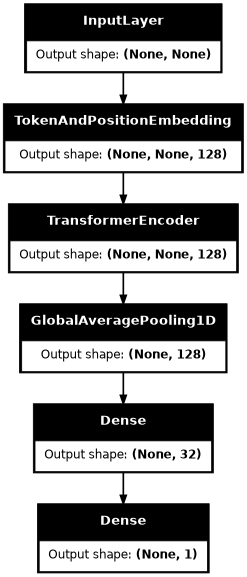

In [3]:
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

# create the input
inputs = layers.Input(shape=(None,))
# token and position embedding
x = keras_nlp.layers.TokenAndPositionEmbedding(vocabulary_size=maxwords, sequence_length=sequence_length, embedding_dim=embed_dim)(inputs)
# transformer
x = keras_nlp.layers.TransformerEncoder(intermediate_dim=ff_dim, num_heads=num_heads, dropout=0.1)(x)
# now we just want co classify the output of our transformer into positive or negative sentiment
# we can use a couple of dense layers to step down from our transformer output to our final classification
# decision
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
plot_model(model, show_shapes=True, dpi=60)

We can now train the network as we normally would.

In [4]:
model.compile("adamw", "binary_crossentropy", metrics=["accuracy"], jit_compile=False)
history = model.fit(training_data_mapped, epochs=20, validation_data=testing_data_mapped)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5907 - loss: 0.6643 - val_accuracy: 0.6451 - val_loss: 0.6276
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6406 - loss: 0.6341 - val_accuracy: 0.6469 - val_loss: 0.6271
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6451 - loss: 0.6310 - val_accuracy: 0.6467 - val_loss: 0.6265
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6464 - loss: 0.6289 - val_accuracy: 0.6467 - val_loss: 0.6279
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6482 - loss: 0.6266 - val_accuracy: 0.6458 - val_loss: 0.6256
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6486 - loss: 0.6242 - val_accuracy: 0.6487 - val_loss: 0.6226
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6523 - loss: 0.6205 - val_accuracy: 0.6456 - val_loss: 0.6244
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6553 -

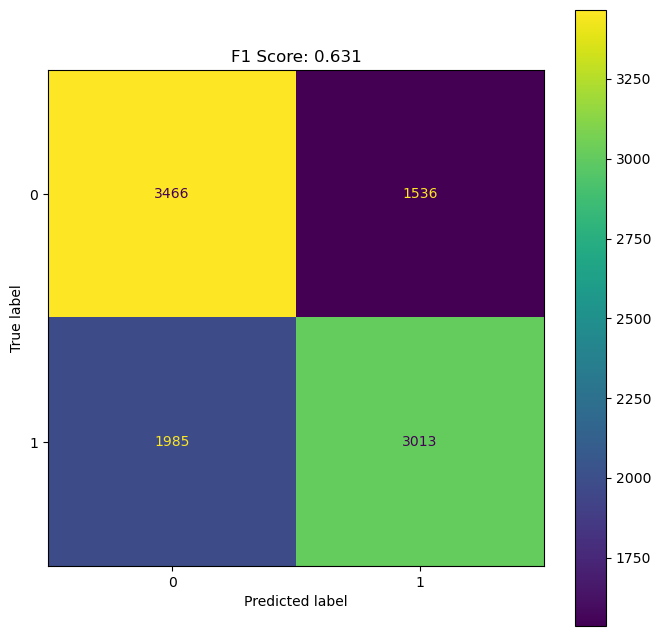

In [5]:
def eval_model(model, x_test, y_test):  
    
    # make predictions
    pred = model.predict(x_test, verbose=False);
    # apply threshold, just pick 0.5
    pred = pred >= 0.5

    # get confusion matrix and F1
    cm = confusion_matrix(y_test, pred)
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)    
    ax.set_title("F1 Score: %1.3f" % f1_score(y_test, pred))

# pull out TF dataset as a numpy array to make it easy to get F1 Score and Confusion Matrix
test_tokens = []
test_labels = []

for i, (x, y) in enumerate(testing_data_mapped.as_numpy_iterator()):
    test_tokens.extend(x)
    test_labels.extend(y)
    
test_tokens = numpy.array(test_tokens)
test_labels = numpy.array(test_labels)

# evaluate
eval_model(model, test_tokens, test_labels)

Our network works pretty well - we're at 77% accuracy on the test set which is the best we've achieved on this data across our various examples.

We've also go there fairly quickly (in terms of epochs/training steps), and are starting to overfit after just two epochs. It's worth noting though that the training time per epoch is a lot slower than our LSTM methods. That said, transformers are a lot easier to parallelise than LSTMs which can make them quite efficient on GPUs.

### Stacked Transformers

Because we can, we'll now stack our transformer blocks. We'll just stack two, and we'll also change up some other parameters (again, because we can).

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ token_and_position_embedding_1  │ (None, None, 128)         │  2,572,288 │
│ (TokenAndPositionEmbedding)     │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_1           │ (None, None, 128)         │     99,584 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_2           │ (None, None, 128)         │     99,584 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d_1      │ (None, 128)               │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 32)                │      4,128 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 1)                 │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,775,617 (10.59 MB)

 Trainable params: 2,775,617 (10.59 MB)

 Non-trainable params: 0 (0.00 B)

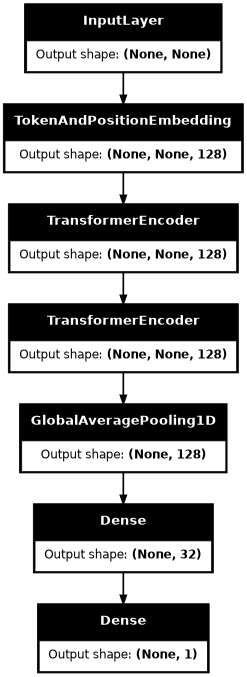

In [6]:
embed_dim = 128  # Embedding size for each token
num_heads = 4  # Number of attention heads, note we've now made this 4
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

# create the input
inputs = layers.Input(shape=(None,))
# token and position embedding
x = keras_nlp.layers.TokenAndPositionEmbedding(vocabulary_size=maxwords, sequence_length=sequence_length, embedding_dim=embed_dim)(inputs)
# transformers
x = keras_nlp.layers.TransformerEncoder(intermediate_dim=ff_dim, num_heads=num_heads, dropout=0.1)(x)
x = keras_nlp.layers.TransformerEncoder(intermediate_dim=ff_dim, num_heads=num_heads, dropout=0.1)(x)
# output
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
plot_model(model, show_shapes=True, dpi=60)

In [7]:
model.compile("adamw", "binary_crossentropy", metrics=["accuracy"], jit_compile=False)
history = model.fit(training_data_mapped, epochs=20, validation_data=testing_data_mapped)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.5589 - loss: 0.6825 - val_accuracy: 0.6327 - val_loss: 0.6420
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6212 - loss: 0.6493 - val_accuracy: 0.6424 - val_loss: 0.6390
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6353 - loss: 0.6410 - val_accuracy: 0.6384 - val_loss: 0.6371
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6371 - loss: 0.6367 - val_accuracy: 0.6350 - val_loss: 0.6430
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6323 - loss: 0.6436 - val_accuracy: 0.6351 - val_loss: 0.6402
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6365 - loss: 0.6361 - val_accuracy: 0.6350 - val_loss: 0.6400
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6374 - loss: 0.6368 - val_accuracy: 0.6441 - val_loss: 0.6327
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6435 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



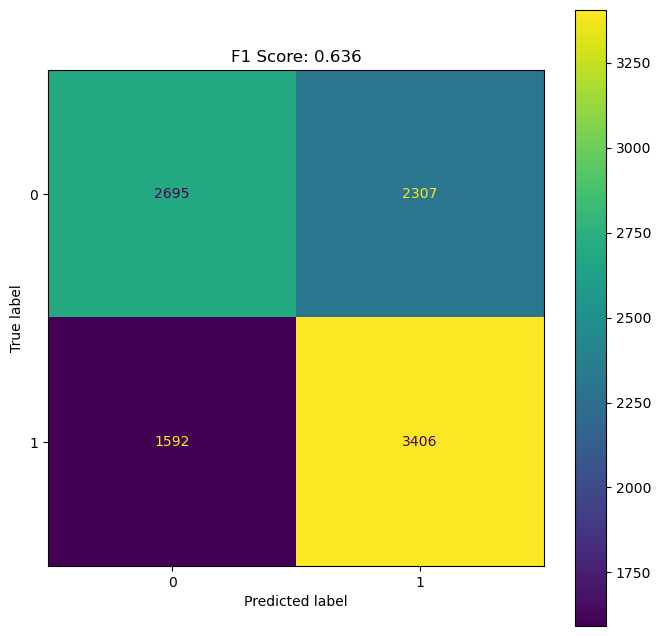

In [8]:
eval_model(model, test_tokens, test_labels)

Performance wise, we're a touch below the first network, but could maybe push this a bit further before overfitting (though this does vary from one training run to the next - typically I'm seeing more severe overfitting for this more complex transformer than the first).

On the whole though, this is working pretty well, though with the stacked transformers is now running a lot slower than our first network (and other networks using this data).

## Final Thoughts

In this example we've had a brief look at transformers. These offer a very powerful way to process sequences, all using the magic of attention.

Their attention formulation is a bit different to what we've looked at in our earlier examples, but the formulation is quite common elsewhere and generally works well.

One thing you may have noted running this example is that it's not that quick. One of the motivations for transformers is that they don't need to process data sequentially, each element in a sequence can be processed simultaenously, while still capturing the relationship between elements. This does offer gains for long sequences and/or when very large compute resources are available, though we don't fit either of those criteria here (assuming you're not running this on some multi-GPU beast). 

While transformers started in text processing, there peformace for that task has seen them adopted elsewhere such as to [images](https://keras.io/examples/vision/image_classification_with_vision_transformer/). The application to images is perhpaps not obvious, as transformers by design operate over sequences. The solution to this is to break an image up into a series of small blocks, encode each of these, and then process it as a sequence. This allows a local feature representation to obtained for a small patch, and then the relationship between these patches to be modelled. By having the position embedding as well, the transformer can maintain knowledge of how patches are located relative to one another. 